# Download and understand the data.

The goal is to look at data from various different angles.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ca_housing_data import CAHousingData

In [2]:
# Load the data-set, each row represents a district (called a census block group).
data = CAHousingData()
df = data.all()

In [3]:
df.head() # Few samples

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
df.shape

(20640, 10)

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

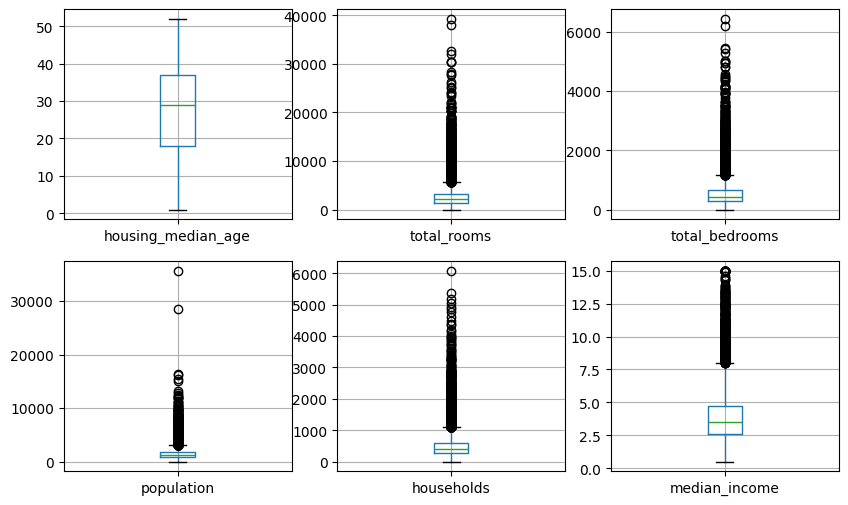

In [7]:
# We will plot of the data
fix, ax = plt.subplots(2,3,figsize=(10, 6))
df.boxplot(column='housing_median_age', ax=ax[0, 0])
df.boxplot(column='total_rooms', ax=ax[0, 1])
df.boxplot(column='total_bedrooms', ax=ax[0, 2])
df.boxplot(column='population', ax=ax[1, 0])
df.boxplot(column='households', ax=ax[1, 1])
df.boxplot(column='median_income', ax=ax[1, 2])
plt.show()

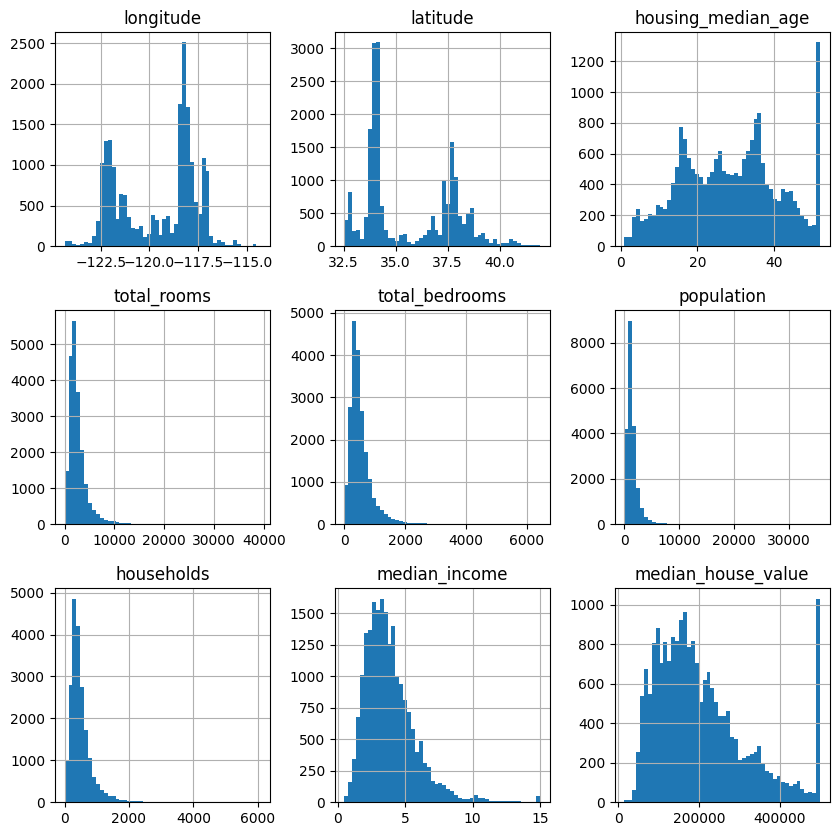

In [8]:
# PLot histogram of the each column
df.hist(figsize=(10, 10), bins=50)
plt.show()


__Observations:__ 
1. Total rooms, bedrooms, population, households and median income has quite a outliers
2. Median is age is almost uniform
3. All columns except 'longitude' are positive.
4. Data has different scale: (_Feature Scaling_)
     - income and age is 10s
     - total bedroom 1,000s
     - population and total rooms: 10,000
4. Missing data for total bedrooms (207 values missing)
5. Tail heavy distributions: median_age and house_value (_Transform to bell-shaped_)
6. Capped data: media age and median value (_Remove them from the dataset_)

Capped data may cause model to learn that price can not go more than x. Either relabel them or
remove them from the training set.

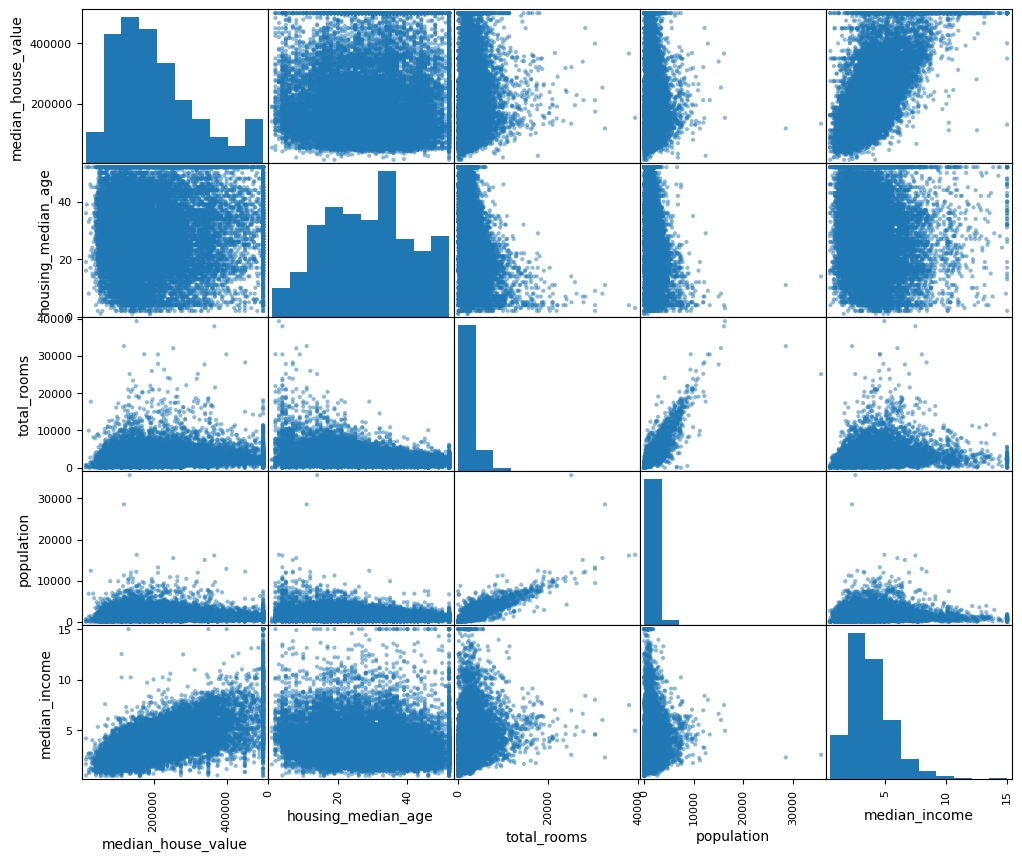

In [9]:
# Show scatter-matrix of the data

pd.plotting.scatter_matrix(df[['median_house_value', 'housing_median_age',
                           'total_rooms', 'population', 'median_income']], figsize=(12, 10))

plt.show()

__Observations:__
1. Median income is correlated to house value. (See below)
2. Other correlations are almost none

In [10]:
# Look at the correlation matrix with house value
corr_matrix = df.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [11]:
# Look at count of categories in ocean_proximity
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

__Remark__: Median income may be an important predictor of house pricing. We like to make sure that test samples are representative of this population. That is use stratified sampling to create test set.

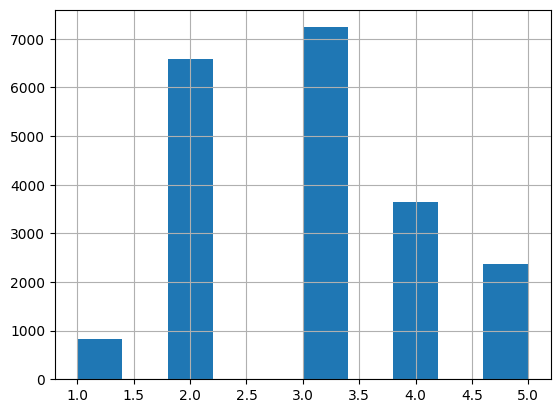

In [12]:
# Create histogram of median income
# Assign 1 => 0-1.5, 2 => 1.5-3, 3 => 3-4.5, 4 => 4.5-6, 5 => 6+
income_categories = data.income_categories()
income_categories.hist()
plt.show()

In [13]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

## Plot the data on a CA map
Uses GeoDataFrame, that adds a geometry column to the DataFrame with CRS (Coordinate Reference System) using WGS84 (EPSG:4326), a lat/long 
standard used by the GPS. Then use `.to_crs()` to project the Lat/Long to Web Mercator. This is for plotting with contextily.  Note that the Web Mercator uses Meters as units, and is a conformal projection, that preserves the angles and shapes of the original data.

In [14]:
import geopandas as gpd
import contextily as ctx

In [15]:
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(
                           df.longitude, df.latitude, crs="EPSG:4326").to_crs(epsg=3857))  # Original GPS Lat/Long
print(f"Type of the geometry column: {type(gdf.geometry)}")

Type of the geometry column: <class 'geopandas.geoseries.GeoSeries'>


In [16]:
gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-13606581.36 4562487.679)
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-13605468.165 4559667.342)
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-13607694.555 4558257.461)
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-13608807.749 4558257.461)
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-13608807.749 4558257.461)


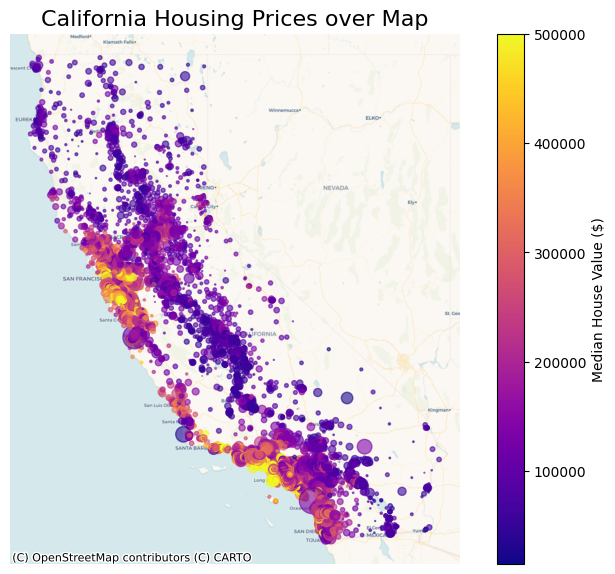

In [17]:
# Plot the data on a map
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(ax=ax,
         column='median_house_value',
         cmap='plasma',
         markersize=gdf['population'] / 100,
         alpha=0.6,
         legend=True,
         legend_kwds={'label': "Median House Value ($)"})

# Add a map background (or basemap), use the CartoDB.Voyager tiles.
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
ax.set_title("California Housing Prices over Map", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()